In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
import cmocean as cmo
import xarray as xr 
import cartopy
import cartopy.crs as ccrs
from scipy.io import loadmat
from scipy.interpolate import interp1d
from sklearn import decomposition
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# LOAD BOTTOM SLOPES 
x = loadmat('/Users/jakesteinberg/Documents/CPT/vertical_structure/CM26_global_slope.mat')
lon0 = x['lon'][:,0]
lat = x['lat'][:,0]
gamma0 = np.transpose(x['gamma']) # eastward 
alpha0 = np.transpose(x['alpha']) # northward 
roughness = np.transpose(x['rms_rough'])
# realign so lon-grid goes from 0-360
roughness = np.concatenate((roughness[:,lon0 >= 0], roughness[:,lon0 < 0]),axis=1)
alpha0 = np.concatenate((alpha0[:,lon0 >= 0], alpha0[:,lon0 < 0]),axis=1)
gamma0 = np.concatenate((gamma0[:,lon0 >= 0], gamma0[:,lon0 < 0]),axis=1)
lon = np.concatenate((lon0[lon0 >= 0], lon0[lon0 < 0]+360))

In [3]:
# LOAD EOFS
cm26_eof_path = '/Users/jakesteinberg/Documents/CPT/models/CM2.6_EOF_analysis.nc'
cmEOF = xr.open_dataset(cm26_eof_path)
# shift EOF longitudes to match with modes 
lon01 = cmEOF.lon.data
eofu1 = np.concatenate((cmEOF.EOF1u[:,:,lon01 >= 0].data, cmEOF.EOF1u[:,:,lon01 < 0].data),axis=2)
eofv1 = np.concatenate((cmEOF.EOF1v[:,:,lon01 >= 0].data, cmEOF.EOF1v[:,:,lon01 < 0].data),axis=2)
lon1 = np.concatenate((lon01[lon01 >= 0], lon01[lon01 < 0]+360))
lat1 = cmEOF.lat.data
data_coords = {'depth': cmEOF.zl.data, 'latitude': lat1, 'longitude': lon1}
EOF1u = xr.DataArray(data=eofu1, dims=['depth','latitude','longitude'], coords=data_coords) 
EOF1v = xr.DataArray(data=eofv1, dims=['depth','latitude','longitude'], coords=data_coords) 
# trim in lat to match N2 data (maybe not needed)
EOF1u_trim = EOF1u[:,4:-25,:]
EOF1v_trim = EOF1v[:,4:-25,:]
lat_trim = lat1[4:-25]
EOF_z = cmEOF.zl.data

In [4]:
# load stratification (for now match N2 to CM2.6 grid)
x = loadmat('/Users/jakesteinberg/Documents/CPT/vertical_structure/global_1deg_N2smooth_slope.mat') # global_n2_2deg_slope.mat')
N2_lon = x['lon'][:,0]    
N2_lon[N2_lon < 0] = 360-np.abs(N2_lon[N2_lon < 0])
N2_lat = x['lat'][:,0]   
N2 = x['N2']      
N2 = np.concatenate((N2[N2_lon < 180,:,:], N2[N2_lon > 180,:,:]),axis=0)
N2_z = -1.*x['dep'][:,0]

In [5]:
lat_band_N = range(10,60)
bin_step = 0.000002
h_bin = np.arange(0.0000001,0.001, bin_step)
bin_cen = h_bin[0:-1] + bin_step
pdfz_N2 = np.nan*np.ones((np.shape(N2)[2],len(h_bin)-1))
for i in range(np.shape(N2)[2]):
    amps = N2[:,lat_band_N,i].flatten() 
    [h_z,h_edge] = np.histogram(amps,bins=h_bin,range=(h_bin[0],h_bin[-1]),density=True)
    pdfz_N2[i,:] = h_z
    
# f, ax = plt.subplots(1,1,figsize=(3,6))
# ax.pcolor(bin_cen,-1*N2_z,pdfz_N2,cmap=plt.get_cmap('jet',len(h_bin)))
# ax.set_ylim([0,3000]); ax.invert_yaxis(); ax.set_xlim([0.0000001,0.00002])

In [6]:
# flip sign for subsequent characterization
eof1u = np.nan*np.ones(np.shape(EOF1u))
eof1v = np.nan*np.ones(np.shape(EOF1u))
for i in tqdm(range(np.shape(EOF1u)[1])):
    for j in range(np.shape(EOF1u)[2]):
        this_eofu = EOF1u[:,i,j].data
        if np.nanmean(this_eofu[0:15]) < 0:
            this_eofu = this_eofu*-1
        eof1u[:,i,j] = this_eofu
        this_eofv = EOF1v[:,i,j].data
        if np.nanmean(this_eofv[0:15]) < 0:
            this_eofv = this_eofv*-1
        eof1v[:,i,j] = this_eofv

100%|██████████| 270/270 [00:39<00:00,  6.89it/s]


Lat S: -76.88469624030638
Lat N: 81.15087103273531
S.O. Lat S: -76.88469624030638
S.O. Lat N: -54.60647373129214


Text(0.5, 1.0, 'S.O. EOF1v PDFz')

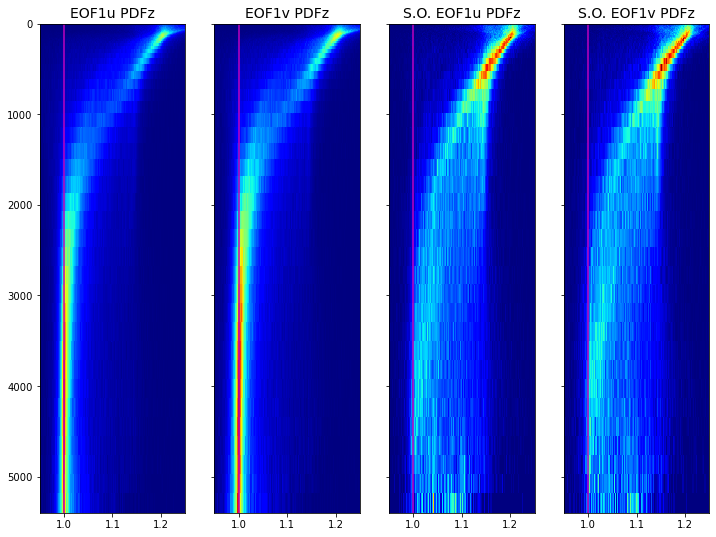

In [7]:
lat_band = range(10,250) # range(70,130)
lat_band_2 = range(10,60)
bin_step = 0.001
h_bin = np.arange(0.5,1.55,bin_step)
bin_cen = h_bin[0:-1] + bin_step
pdfz_u = np.nan*np.ones((np.shape(EOF1u)[0],len(h_bin)-1))
pdfz_v = np.nan*np.ones((np.shape(EOF1u)[0],len(h_bin)-1))
pdfz_u_2 = np.nan*np.ones((np.shape(EOF1u)[0],len(h_bin)-1))
pdfz_v_2 = np.nan*np.ones((np.shape(EOF1u)[0],len(h_bin)-1))
for i in range(np.shape(EOF1u)[0]):
    amps = eof1u[i,lat_band,:].flatten() + 1
    [h_z,h_edge] = np.histogram(amps,bins=h_bin,range=(h_bin[0],h_bin[-1]),density=True)
    pdfz_u[i,:] = h_z
    amps = eof1v[i,lat_band,:].flatten() + 1
    [h_z,h_edge] = np.histogram(amps,bins=h_bin,range=(h_bin[0],h_bin[-1]),density=True)
    pdfz_v[i,:] = h_z
    # -- band 2 -- 
    amps = eof1u[i,lat_band_2,:].flatten() + 1
    [h_z,h_edge] = np.histogram(amps,bins=h_bin,range=(h_bin[0],h_bin[-1]),density=True)
    pdfz_u_2[i,:] = h_z
    amps = eof1v[i,lat_band_2,:].flatten() + 1
    [h_z,h_edge] = np.histogram(amps,bins=h_bin,range=(h_bin[0],h_bin[-1]),density=True)
    pdfz_v_2[i,:] = h_z

print('Lat S: ' + str(lat1[lat_band[0]])); print('Lat N: ' + str(lat1[lat_band[-1]]));
print('S.O. Lat S: ' + str(lat1[lat_band_2[0]])); print('S.O. Lat N: ' + str(lat1[lat_band_2[-1]]));
f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(12,9),sharey=True,sharex=True)
ax1.pcolor(bin_cen,EOF1u.depth.data,pdfz_u,cmap=plt.get_cmap('jet',len(h_bin)))
ax1.plot([1,1],[0,5500],color='m'); ax1.set_title('EOF1u PDFz',fontsize=14)
ax1.set_xlim([0.95,1.25]); ax1.set_ylim([0,5400]);ax1.invert_yaxis()
ax2.pcolor(bin_cen,EOF1u.depth.data,pdfz_v,cmap=plt.get_cmap('jet',len(h_bin)))
ax2.plot([1,1],[0,5500],color='m'); ax2.set_title('EOF1v PDFz',fontsize=14)
# ax2.set_xlim([0.95,1.25]); ax2.set_ylim([0,5400]); ax2.set_yticklabels(''); ax2.invert_yaxis()
ax3.pcolor(bin_cen,EOF1u.depth.data,pdfz_u_2,cmap=plt.get_cmap('jet',len(h_bin)))
ax3.plot([1,1],[0,5500],color='m'); ax3.set_title('S.O. EOF1u PDFz',fontsize=14)
ax4.pcolor(bin_cen,EOF1u.depth.data,pdfz_v_2,cmap=plt.get_cmap('jet',len(h_bin)))
ax4.plot([1,1],[0,5500],color='m'); ax4.set_title('S.O. EOF1v PDFz',fontsize=14)
# ax2.set_xlim([0.95,1.25]); ax2.set_ylim([0,5400]); ax2.set_yticklabels(''); ax2.invert_yaxis()

In [8]:
# move forward with subset in lat, prep for depth manipulation  
eof1u_t = eof1u[:,lat_band,:]
eof1v_t = eof1v[:,lat_band,:]
X_train0 = np.reshape(eof1u_t,(np.shape(eof1u_t)[0],np.shape(eof1u_t)[1]*np.shape(eof1u_t)[2]))
X_train1 = np.reshape(eof1v_t,(np.shape(eof1v_t)[0],np.shape(eof1v_t)[1]*np.shape(eof1v_t)[2]))

In [7]:
# OPTION 1
# subset depth 
dep_trim = 40
print(EOF_z[dep_trim])
good = []
for i in tqdm(range(np.shape(X_train0)[1])):
    if np.sum(np.isnan(X_train0[0:dep_trim,i])) < 1:
        good.append(i)
# len(good)/np.shape(X_train0)[1]
good1 = []
for i in tqdm(range(np.shape(X_train1)[1])):
    if np.sum(np.isnan(X_train1[0:dep_trim,i])) < 1:
        good1.append(i)

 41%|████      | 16224/39600 [00:00<00:00, 162230.49it/s]

3508.633056640625


100%|██████████| 39600/39600 [00:00<00:00, 169487.93it/s]


In [ ]:
# -- trim in depth (NON-RESCALED OPTION) (OPTION 1)
deci = 2
X_trainu = X_train0[0:dep_trim,good]
X_trainu = X_trainu # [:,0::deci]
X_trainv = X_train1[0:dep_trim,good]
X_trainv = X_trainv # [:,0::deci]
dep_train = EOF1u.depth.data[0:dep_trim]
# -- place on uniform vertical grid
dep_grid = np.arange(10,dep_train[-1],20)
X_trainU = np.nan*np.ones((len(dep_grid), np.shape(X_trainu)[1]))
X_trainV = np.nan*np.ones((len(dep_grid), np.shape(X_trainv)[1]))
for i in range(np.shape(X_trainu)[1]):
    X_trainU[:,i] = np.interp(dep_grid,dep_train,X_trainu[:,i])
    X_trainV[:,i] = np.interp(dep_grid,dep_train,X_trainv[:,i])

In [ ]:
# -- sampe plot of select EOFS (for non-rescaled, OPTION 1)
f, ax = plt.subplots(1,1,figsize=(3,6))
for i in range(100):
    ax.plot(X_trainV[:,i],dep_grid,linewidth=0.5)
ax.set_xlim([-0.15,0.4])
ax.invert_yaxis()
ax.grid()

In [9]:
# OPTION 2
# rescale in depth so surface is zero and bottom is one 
rs_grid = np.arange(0,1,0.02)
rs_train_u = np.nan*np.ones((len(rs_grid), np.shape(X_train0)[1]))
rs_train_v = np.nan*np.ones((len(rs_grid), np.shape(X_train0)[1]))
for i in tqdm(range(np.shape(X_train0)[1])): #range(916,917): # 
    this_p_u = X_train0[:,i] 
    this_p_v = X_train1[:,i]
    if np.sum(np.isnan(this_p_u)) > (len(this_p_u) - 5):
        continue
    g = np.where(~np.isnan(this_p_u))[0]
    max_dep = np.nanmax(EOF_z[g])
    if (len(g) > 10) & (np.nanmax(EOF_z[g]) > 1000):
        rs_train_u[:,i] = np.interp(rs_grid,EOF_z[g]/max_dep,this_p_u[g])
        rs_train_v[:,i] = np.interp(rs_grid,EOF_z[g]/max_dep,this_p_v[g])
good = np.where(~np.isnan(rs_train_u[10,:]))[0]
rs_train_u = rs_train_u[:,good]
rs_train_v = rs_train_v[:,good]
X_trainU = rs_train_u
X_trainV = rs_train_v

100%|██████████| 86400/86400 [00:02<00:00, 34506.72it/s]


In [11]:
# compare sizes after remove land/nan profiles 
print(np.shape(X_train0))
print(np.shape(rs_train_u))

(50, 86400)
(50, 45064)


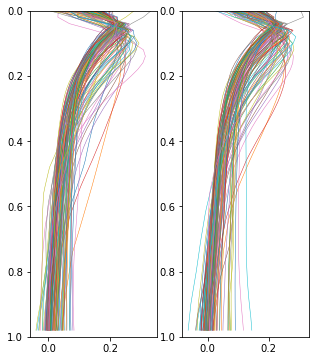

In [12]:
# sample set of rescaled profiles (OPTION 2)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(5,6))
for i in range(100):
    ax1.plot(rs_train_u[:,i],rs_grid,linewidth=0.5)
    ax2.plot(rs_train_v[:,i],rs_grid,linewidth=0.5)
ax1.set_ylim([0,1])
ax1.invert_yaxis()
ax2.set_ylim([0,1])
ax2.invert_yaxis()

In [13]:
# -- create lat/lon grid to subsample and re-shape
# -- for either re-scaled or not -- 
Lon,Lat = np.meshgrid(lon1,lat1)
Lon_t = Lon[lat_band,:]
Lat_t = Lat[lat_band,:]
LonR = np.reshape(Lon_t,(np.shape(eof1u_t)[1]*np.shape(eof1u_t)[2]))
LatR = np.reshape(Lat_t,(np.shape(eof1u_t)[1]*np.shape(eof1u_t)[2]))
lon_train = LonR[good]
lon_train = lon_train # [0::deci]
lat_train = LatR[good]
lat_train = lat_train # [0::deci]

In [243]:
# prep for GMM
# -- normalization = preprocessing.normalize (n_norm=l2) # all values vary between zero and one 
# procedure to follow 
# https://github.com/DanJonesOcean/OceanClustering

# Elizabeth
# v_eddy_r = preprocessing.normalize(v_eddy_r,norm='max')

In [14]:
# PCA (U)
pca = decomposition.PCA(n_components=6) 
# fit the PCA to the training data 
pca.fit(np.transpose(X_trainU))
# transform the training data to reduced PCA/EOF space
X_pca_train = pca.transform(np.transpose(X_trainU))
# X_pca_inv = pca.inverse_transform(np.transpose(X_train1))
# get the variance explained by each principal component
variance_sum = np.cumsum(pca.explained_variance_ratio_)

In [15]:
pca = decomposition.PCA(n_components=6) 

In [16]:
pca.fit(np.transpose(X_trainU))

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [18]:
# PCA (V)
pcaV = decomposition.PCA(n_components=6) 
# fit the PCA to the training data 
pcaV.fit(np.transpose(X_trainV))
# transform the training data to reduced PCA/EOF space
X_pca_trainV = pcaV.transform(np.transpose(X_trainV))
# X_pca_inv = pca.inverse_transform(np.transpose(X_train1))
# get the variance explained by each principal component
variance_sumV = np.cumsum(pcaV.explained_variance_ratio_)

In [ ]:
# -- ELZIABETH -- 
############# PCA ################
# -- PCA on total spectra flattened array
# pca = PCA(0.95)  #pca that accounts for 95% of the data; alternatively say number of PCs
# lower_dimensional_data = pca.fit_transform(np.transpose(v_eddy_norm))  # [depth x profile number]
# print(lower_dimensional_data.shape)
# -- GMM on lower dimensional data
# gmm = GaussianMixture(n_components=4, covariance_type='full').fit(lower_dimensional_data)
# labels = gmm.predict(lower_dimensional_data)
# print(labels.shape)
# -- ELIZABETH -- 

In [106]:
np.shape(X_pca_train)

(45064, 6)

In [72]:
n_clusters = 6
gmmU = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(X_pca_train)
gmmV = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(X_pca_trainV)
labelsU = gmmU.predict(X_pca_train)
labelsV = gmmV.predict(X_pca_trainV)

In [73]:
cluster_mapU = np.nan*np.ones((len(lat1),len(lon1)))
cluster_mapV = np.nan*np.ones((len(lat1),len(lon1)))
for i in range(len(labelsU)):
    this_lon = lon_train[i]
    this_lat = lat_train[i]
    loc_lon = np.where(lon1 == this_lon)[0]
    loc_lat = np.where(lat1 == this_lat)[0]
    cluster_mapU[loc_lat,loc_lon] = labelsU[i]
    cluster_mapV[loc_lat,loc_lon] = labelsV[i]

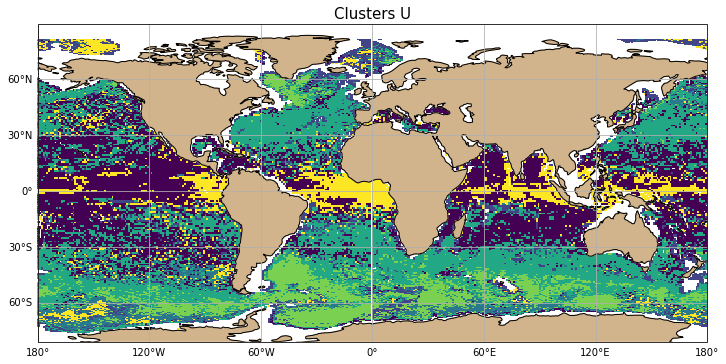

In [100]:
f, ax = plt.subplots(1,1,figsize=(12,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
ax.pcolor(lon1,lat1,cluster_mapU, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('viridis',n_clusters), vmin=0, vmax=n_clusters) 
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True); ax.set_title('Clusters U',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_07_19/clusters5_V.jpg', dpi=300)

Text(0, 0.5, 'Normalized Depth')

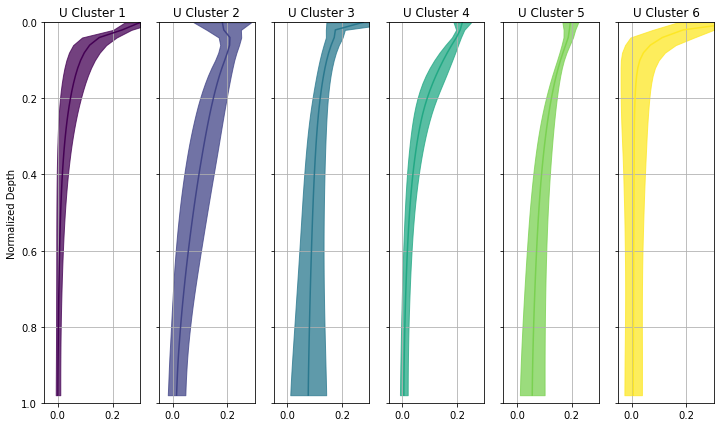

In [101]:
colors = plt.get_cmap('viridis',n_clusters)
f, ax = plt.subplots(1,n_clusters,figsize=(12,7),sharey=True)
for i in range(n_clusters):
    li = X_trainU[:,labelsU==i]
    ax[i].plot(np.nanmean(li,axis=1),rs_grid, color=colors(i))
    ax[i].fill_betweenx(rs_grid,np.nanmean(li,axis=1)-np.nanstd(li,axis=1),x2=np.nanmean(li,axis=1)+np.nanstd(li,axis=1), color=colors(i), alpha=0.75)
    ax[i].set_xlim([-0.05,0.3]); ax[i].set_ylim([0,1]); ax[i].grid()
    ax[i].set_title('U Cluster ' + str(i+1))
ax[0].invert_yaxis(); ax[0].set_ylabel('Normalized Depth')
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_07_19/clusters5_V_profiles.jpg', dpi=300)

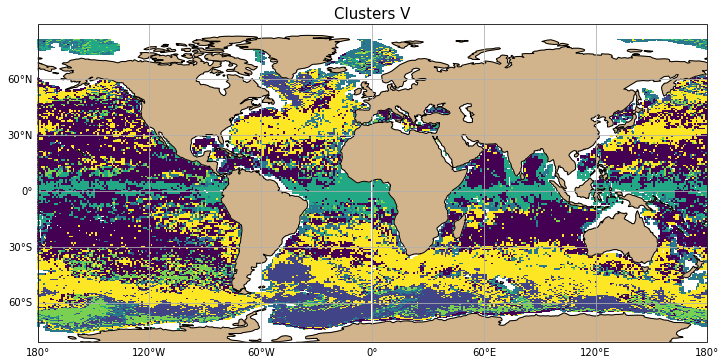

In [74]:
f, ax = plt.subplots(1,1,figsize=(12,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
ax.pcolor(lon1,lat1,cluster_mapV, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('viridis',n_clusters), vmin=0, vmax=n_clusters) 
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True); ax.set_title('Clusters V',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_07_19/clusters5_V.jpg', dpi=300)

Text(0, 0.5, 'Normalized Depth')

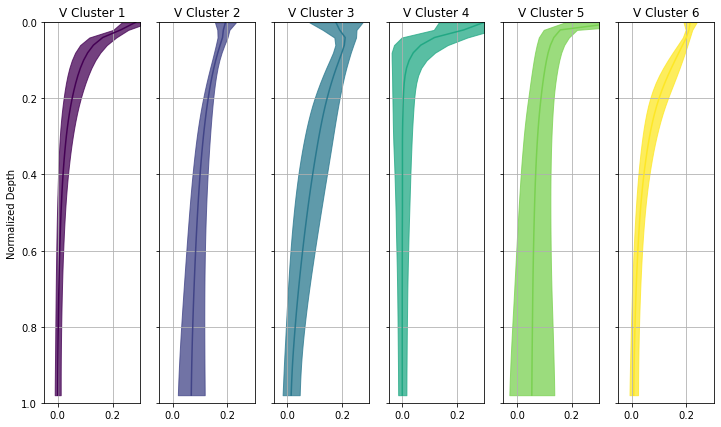

In [76]:
colors = plt.get_cmap('viridis',n_clusters)
f, ax = plt.subplots(1,n_clusters,figsize=(12,7),sharey=True)
for i in range(n_clusters):
    li = X_trainV[:,labelsV==i]
    ax[i].plot(np.nanmean(li,axis=1),rs_grid, color=colors(i))
    ax[i].fill_betweenx(rs_grid,np.nanmean(li,axis=1)-np.nanstd(li,axis=1),x2=np.nanmean(li,axis=1)+np.nanstd(li,axis=1), color=colors(i), alpha=0.75)
    ax[i].set_xlim([-0.05,0.3]); ax[i].set_ylim([0,1]); ax[i].grid()
    ax[i].set_title('V Cluster ' + str(i+1))
ax[0].invert_yaxis(); ax[0].set_ylabel('Normalized Depth')
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_07_19/clusters5_V_profiles.jpg', dpi=300)

In [104]:
rough_in = []
for i in range(n_clusters):
    cluster_loc_i = np.where(cluster_mapV == i)
    rough_in_i = []
    for j in tqdm(range(len(cluster_loc_i[0]))):
        this_lon = Lon[cluster_loc_i[0][j],cluster_loc_i[1][j]]
        this_lat = Lat[cluster_loc_i[0][j],cluster_loc_i[1][j]]
        r_lon_in = np.where((lon > (this_lon - 0.2)) & (lon < (this_lon + 0.2)))
        r_lat_in = np.where((lat > (this_lat - 0.2)) & (lat < (this_lat + 0.2)))
        rough_in_i.append(np.nanmean(roughness[r_lat_in][:,r_lon_in]))
    rough_in.append(rough_in_i)

100%|██████████| 13217/13217 [00:02<00:00, 4554.93it/s]


Text(0.5, 1.0, 'Meridional Velocity')

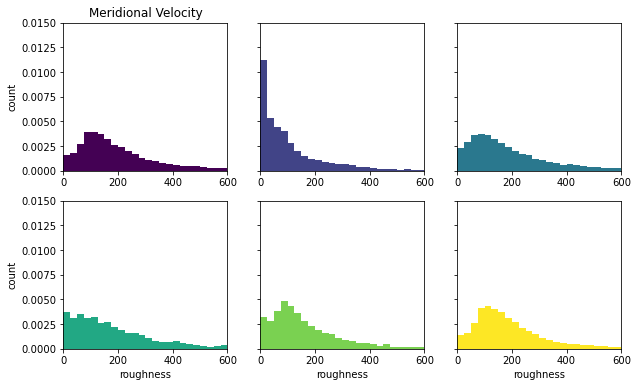

In [105]:
f, ax = plt.subplots(2,3,figsize=(10,6))
gax = ax.flatten()
for i in range(n_clusters):
    nn = gax[i].hist(rough_in[i],bins=np.arange(0,1000,25),color=colors(i),density=True)
    # gax[i].set_ylim([10,1000])
    # gax[i].set_yscale('log')
    gax[i].set_ylim([0,0.015]); gax[i].set_xlim([0,600])
    if (i == 1) | (i == 2) | (i == 4) | (i == 5):
        gax[i].set_yticklabels('')
    if (i == 0) | (i == 3):
        gax[i].set_ylabel('count')
    if i > 2:
        gax[i].set_xlabel('roughness')
gax[0].set_title('Meridional Velocity')

In [102]:
rough_in = []
for i in range(n_clusters):
    cluster_loc_i = np.where(cluster_mapU == i)
    rough_in_i = []
    for j in tqdm(range(len(cluster_loc_i[0]))):
        this_lon = Lon[cluster_loc_i[0][j],cluster_loc_i[1][j]]
        this_lat = Lat[cluster_loc_i[0][j],cluster_loc_i[1][j]]
        r_lon_in = np.where((lon > (this_lon - 0.2)) & (lon < (this_lon + 0.2)))
        r_lat_in = np.where((lat > (this_lat - 0.2)) & (lat < (this_lat + 0.2)))
        rough_in_i.append(np.nanmean(roughness[r_lat_in][:,r_lon_in]))
    rough_in.append(rough_in_i)

100%|██████████| 4119/4119 [00:00<00:00, 5182.21it/s]


Text(0.5, 1.0, 'Zonal Velocity')

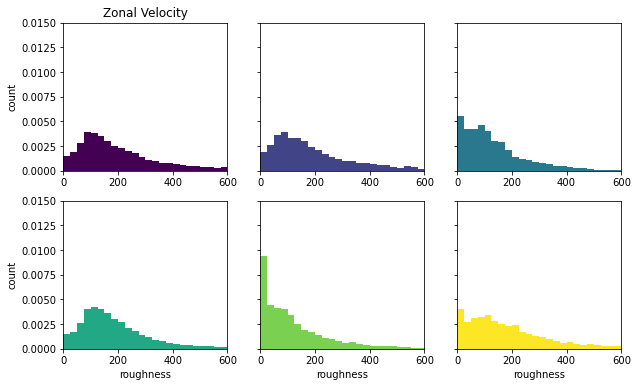

In [103]:
f, ax = plt.subplots(2,3,figsize=(10,6))
gax = ax.flatten()
for i in range(n_clusters):
    nn = gax[i].hist(rough_in[i],bins=np.arange(0,1000,25),color=colors(i),density=True)
    # gax[i].set_ylim([10,1000])
    # gax[i].set_yscale('log')
    gax[i].set_ylim([0,0.015]); gax[i].set_xlim([0,600])
    if (i == 1) | (i == 2) | (i == 4) | (i == 5):
        gax[i].set_yticklabels('')
    if (i == 0) | (i == 3):
        gax[i].set_ylabel('count')
    if i > 2:
        gax[i].set_xlabel('roughness')
gax[0].set_title('Zonal Velocity')

[]

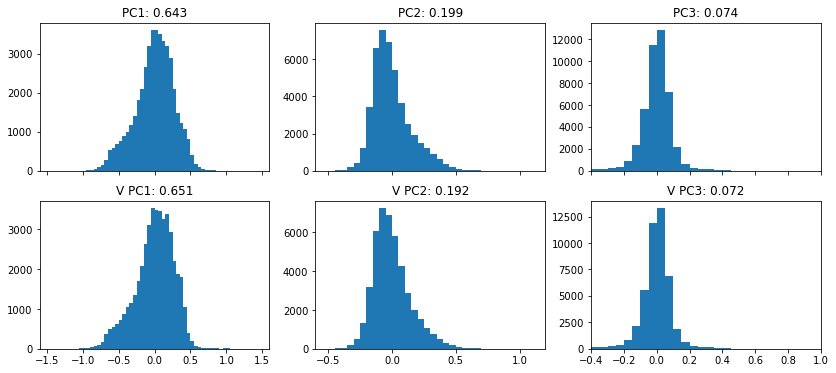

In [25]:
# PCA amplitudes 
f, ax = plt.subplots(2,3,figsize=(14,6))
n1 = ax[0,0].hist(X_pca_train[:,0],bins=np.arange(-1.6,1.6,0.05)) # pca.components_[0,:]
ax[0,0].set_title('PC1: ' + str(np.round(pca.explained_variance_ratio_[0],3)))
n2 = ax[0,1].hist(X_pca_train[:,1],bins=np.arange(-0.6,1.2,0.05))
ax[0,1].set_title('PC2: ' + str(np.round(pca.explained_variance_ratio_[1],3)))
n2 = ax[0,2].hist(X_pca_train[:,2],bins=np.arange(-0.4,1,0.05))
ax[0,2].set_title('PC3: ' + str(np.round(pca.explained_variance_ratio_[2],3)))

n1 = ax[1,0].hist(X_pca_trainV[:,0],bins=np.arange(-1.6,1.6,0.05)) # pca.components_[0,:]
ax[1,0].set_title('V PC1: ' + str(np.round(pcaV.explained_variance_ratio_[0],3)))
n2 = ax[1,1].hist(X_pca_trainV[:,1],bins=np.arange(-0.6,1.2,0.05))
ax[1,1].set_title('V PC2: ' + str(np.round(pcaV.explained_variance_ratio_[1],3)))
n2 = ax[1,2].hist(X_pca_trainV[:,2],bins=np.arange(-0.4,1,0.05))
ax[1,2].set_title('V PC3: ' + str(np.round(pcaV.explained_variance_ratio_[2],3)))

ax[0,0].set_xlim([-1.6,1.6]); ax[1,0].set_xlim([-1.6,1.6]); ax[0,0].set_xticklabels('')
ax[0,1].set_xlim([-0.6,1.2]); ax[1,1].set_xlim([-0.6,1.2]); ax[0,1].set_xticklabels('')
ax[0,2].set_xlim([-0.4,1]); ax[1,2].set_xlim([-0.4,1]); ax[0,2].set_xticklabels('')

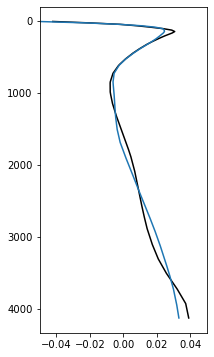

In [139]:
# test ability to reconstruct based on principle components and amplitudes 
s_i = 1
# recon = pca.components_[0,s_i]*X_pca_train[:,0] + pca.components_[1,s_i]*X_pca_train[:,1] + pca.components_[2,s_i]*X_pca_train[:,2] 
recon = pca.components_[0,:]*X_pca_train[s_i,0] + pca.components_[1,:]*X_pca_train[s_i,1] + \
    pca.components_[2,:]*X_pca_train[s_i,2] + pca.components_[3,:]*X_pca_train[s_i,3] + \
    pca.components_[4,:]*X_pca_train[s_i,4]  + pca.components_[5,:]*X_pca_train[s_i,5] 
f, ax = plt.subplots(1,1,figsize=(3,6))
ax.plot(X_trainU[:,s_i] - np.nanmean(X_trainU,axis=1),dep_grid, color='k')
ax.plot(recon,dep_grid)
ax.set_xlim([-0.05,0.05])
ax.invert_yaxis()

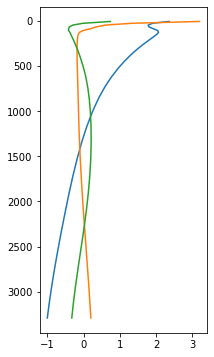

In [250]:
f, ax = plt.subplots(1,1,figsize=(3,6))
ax.plot(X_pca_train[:,0],dep_grid)
ax.plot(X_pca_train[:,1],dep_grid)
ax.plot(X_pca_train[:,2],dep_grid)
ax.invert_yaxis()

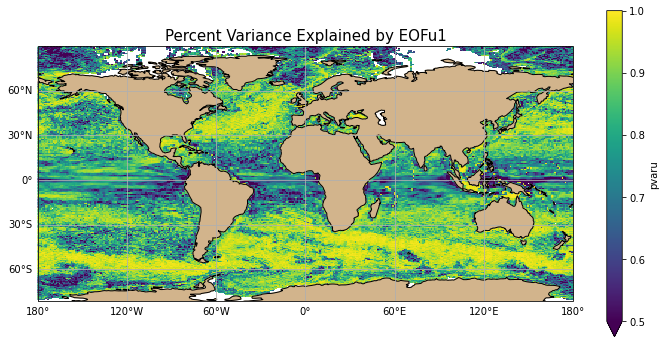

In [29]:
f, ax = plt.subplots(1,1,figsize=(12,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
cmEOF.pvaru.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=plt.get_cmap('viridis'), add_colorbar=True, vmin=0.5,vmax=1) 
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True)
ax.set_title('Percent Variance Explained by EOFu1',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_06_14/eof_pct_var.jpg', dpi=300)

In [7]:
# LOAD CMN2
cm26_n2_path = '/Users/jakesteinberg/Documents/CPT/models/CM2.6_N2_gsw.nc'
cmN2 = xr.open_dataset(cm26_n2_path)
lon02 = cmN2.xu_ocean.data
N2_s = np.concatenate((cmN2.N2[:,:,lon02 >= 0].data, cmN2.N2[:,:,lon02 < 0].data),axis=2)
N2_s_z = cmN2.depth.data
lon2 = np.concatenate((lon02[lon02 >= 0], lon02[lon02 < 0]+360))
lat2 = cmN2.yu_ocean.data

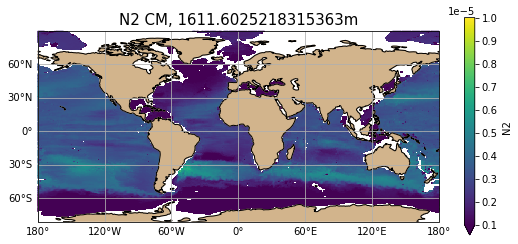

In [8]:
z_i = 30
f, ax = plt.subplots(1,1,figsize=(9,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
cmN2.N2[z_i].plot(ax=ax,transform=ccrs.PlateCarree(), cmap=plt.get_cmap('viridis'),add_colorbar=True, vmin=0.000001,vmax=0.00001) 
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True)
ax.set_title('N2 CM, ' + str(cmN2.depth[z_i].data) + 'm',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_06_14/eof_pct_var.jpg', dpi=300)

In [6]:
# load stratification (for now match N2 to CM2.6 grid)
x = loadmat('/Users/jakesteinberg/Documents/CPT/vertical_structure/global_1deg_N2smooth_slope.mat') # global_n2_2deg_slope.mat')
N2_lon = x['lon'][:,0]    
N2_lon[N2_lon < 0] = 360-np.abs(N2_lon[N2_lon < 0])
N2_lat = x['lat'][:,0]   
N2 = x['N2']      
N2 = np.concatenate((N2[N2_lon < 180,:,:], N2[N2_lon > 180,:,:]),axis=0)
N2_lon = np.concatenate((N2_lon[N2_lon < 180], N2_lon[N2_lon > 180]))
N2_z = -1.*x['dep'][:,0]

In [18]:
N2_z[58]

-1600.0

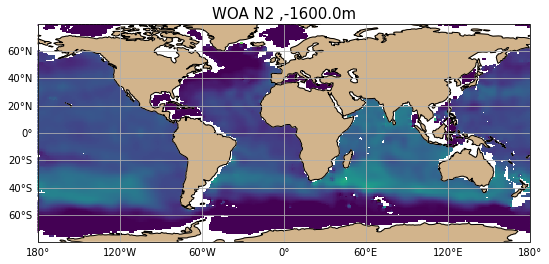

In [19]:
z_i = 58
f, ax = plt.subplots(1,1,figsize=(9,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
ax.pcolor(N2_lon,N2_lat,np.transpose(N2[:,:,z_i]),transform=ccrs.PlateCarree(),\
          cmap=plt.get_cmap('viridis'),vmin=0.000001,vmax=0.00001)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True)
ax.set_title('WOA N2 ,' + str(N2_z[z_i]) + 'm',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_06_14/eof_pct_var.jpg', dpi=300)

In [16]:
# DEFINE NEW GRID TO SMOOTH TO (faster computation time...at a desired resolution)
lon_step = 2
lat_step = 2 
z_step = 100
lon_grid = np.arange(0,360,lon_step)
lat_grid = np.arange(-78,78,lat_step)
z_grid = EOF_z # np.arange(0,6000,z_step)
N2_out = np.nan*np.ones((len(z_grid),len(lat_grid),len(lon_grid)))
EOFu_out = np.nan*np.ones((len(z_grid),len(lat_grid),len(lon_grid)))
EOFv_out = np.nan*np.ones((len(z_grid),len(lat_grid),len(lon_grid)))
alpha_out = np.nan*np.ones((len(lat_grid),len(lon_grid)))
gamma_out = np.nan*np.ones((len(lat_grid),len(lon_grid)))
for i in tqdm(range(len(lon_grid))):
    for j in range(len(lat_grid)):
        t_lon = lon_grid[i]
        t_lat = lat_grid[j]
        # lat/lon = gamma,alpha
        # lat_trim/lon1 = EOFs
        # N2_lat/N2_lon = N2
        s_lon_in = np.where((lon > (t_lon-lon_step/2)) & (lon < (t_lon+lon_step/2)))[0]
        s_lat_in = np.where((lat > (t_lat-lat_step/2)) & (lat < (t_lat+lat_step/2)))[0]
        
        E_lon_in = np.where((lon1 > (t_lon-lon_step/2)) & (lon1 < (t_lon+lon_step/2)))[0]
        E_lat_in = np.where((lat_trim > (t_lat-lat_step/2)) & (lat_trim < (t_lat+lat_step/2)))[0]
        
        # N_lon_in = np.where((N2_lon > (t_lon-lon_step)) & (N2_lon < (t_lon+lon_step)))[0]
        # N_lat_in = np.where((N2_lat > (t_lat-lat_step)) & (N2_lat < (t_lat+lat_step)))[0]
        # N2_int = np.nanmean(np.nanmean(N2[N_lon_in][:,N_lat_in,:],axis=0),axis=0)
        
        N_lon_in = np.where((lon2 > (t_lon-lon_step/2)) & (lon2 < (t_lon+lon_step/2)))[0]
        N_lat_in = np.where((lat2 > (t_lat-lat_step/2)) & (lat2 < (t_lat+lat_step/2)))[0]
        N2_int = np.nanmean(np.nanmean(N2_s[:,N_lat_in][:,:,N_lon_in],axis=1),axis=1)
        
        if len(np.where(~np.isnan(N2_int))[0]) < 5:
            continue
            
        # -- print('good')
        # -- adjust N2 grid 
        z_in = 1*N2_s_z[~np.isnan(N2_int)]
        good = np.where(z_grid <= np.nanmax(z_in))[0]
        N2_out[good,j,i] = np.interp(z_grid[good],1*N2_s_z, N2_int)
        # N2_out[:,j,i] = N2_int
        
        alpha_out[j,i] = np.nanmean(np.nanmean(alpha0[s_lat_in][:,s_lon_in],axis=0),axis=0)
        gamma_out[j,i] = np.nanmean(np.nanmean(gamma0[s_lat_in][:,s_lon_in],axis=0),axis=0)
        
        EOFu_int = EOF1u_trim[:,E_lat_in][:,:,E_lon_in]
        EOFv_int = EOF1v_trim[:,E_lat_in][:,:,E_lon_in]
        deepest_i = np.nan*np.ones((len(E_lat_in),len(E_lon_in)))
        for k in range(len(E_lat_in)):
            for l in range(len(E_lon_in)):
                # -- flip sign before average for a mean EOF 
                if np.nanmean(EOFu_int[0:4,k,l]) < 0:
                    EOFu_int[:,k,l] = -1*EOFu_int[:,k,l]
                if np.nanmean(EOFv_int[0:4,k,l]) < 0:    
                    EOFv_int[:,k,l] = -1*EOFv_int[:,k,l]
                
                # -- max depth of EOF (only average EOFs extending to nearby depth)
                if len(np.where(~np.isnan(EOFu_int[:,k,l]))[0]) > 10:
                    deepest_i[k,l] = np.where(~np.isnan(EOFu_int[:,k,l]))[0][-1]
                    
        deepest = np.nanmax(deepest_i)
        matching_ind = np.where(deepest_i >= deepest-3)
        # -- new set of EOFs to average over 
        EOFu_int_2 = EOFu_int[:,matching_ind[0],matching_ind[1]]
        EOFv_int_2 = EOFv_int[:,matching_ind[0],matching_ind[1]]
        contr_prof = np.shape(EOFu_int_2)[1]*np.shape(EOFu_int_2)[2]
        # -- average across all EOFs satisfying depth requirement
        # EOFu_out[:,j,i] = np.nanmean(np.nanmean(EOFu_int[:,matching_ind[0],matching_ind[1]],axis=1),axis=1)
        # -- OR -- average only if there are enough EOFs at each depth 
        for m in range(np.shape(EOFu_int_2)[0]):
            if np.sum(~np.isnan(EOFu_int_2[m,:,:])) > (contr_prof-3):
                EOFu_out[m,j,i] = np.nanmean(EOFu_int_2[m,:,:])
                EOFv_out[m,j,i] = np.nanmean(EOFv_int_2[m,:,:])
        
        # EOFu_out[good,j,i] = np.interp(z_grid[good],EOF_z,EOFu_int)   
        # EOFv_int = np.nanmean(np.nanmean(EOF1v_trim[:,E_lat_in][:,:,E_lon_in],axis=1),axis=1)
        # EOFv_out[:,j,i] = EOFv_int
        # EOFv_out[good,j,i] = np.interp(z_grid[good],EOF_z,EOFv_int)   

100%|██████████| 180/180 [10:24<00:00,  3.47s/it]


In [17]:
# construct output data array
data_coords = {'depth': z_grid, 'latitude': lat_grid, 'longitude': lon_grid}
N2_da = xr.DataArray(data=N2_out, dims=['depth','latitude','longitude'], coords=data_coords) 
EOFu_da = xr.DataArray(data=EOFu_out, dims=['depth','latitude','longitude'], coords=data_coords) 
EOFv_da = xr.DataArray(data=EOFv_out, dims=['depth','latitude','longitude'], coords=data_coords) 
data_coords = {'latitude': lat_grid, 'longitude': lon_grid}
alpha_da = xr.DataArray(data=alpha_out, dims=['latitude','longitude'], coords=data_coords) 
gamma_da = xr.DataArray(data=gamma_out, dims=['latitude','longitude'], coords=data_coords) 

In [18]:
pct_decay = np.nan*np.ones((len(EOFu_da.latitude),len(EOFu_da.longitude)))
pct_decay_v = np.nan*np.ones((len(EOFu_da.latitude),len(EOFu_da.longitude)))
for i in tqdm(range(len(EOFu_da.longitude))):
    for j in range(len(EOFu_da.latitude)):
        if len(np.where(~np.isnan(EOFu_da[:,j,i]))[0]) > 5:
            gi = np.where(~np.isnan(EOFu_da[:,j,i]))[0]
            pct_decay[j,i] = np.nanmean(EOFu_da[gi[-4:],j,i]) / np.nanmean(EOFu_da[0:4,j,i])
            pct_decay_v[j,i] = np.nanmean(EOFv_da[gi[-4:],j,i]) / np.nanmean(EOFv_da[0:4,j,i])

100%|██████████| 180/180 [00:20<00:00,  8.93it/s]


In [19]:
data_coords = {'latitude': lat_grid, 'longitude': lon_grid}
pct_decay_da = xr.DataArray(data=pct_decay, dims=['latitude','longitude'], coords=data_coords) 
pct_decay_v_da = xr.DataArray(data=pct_decay_v, dims=['latitude','longitude'], coords=data_coords) 

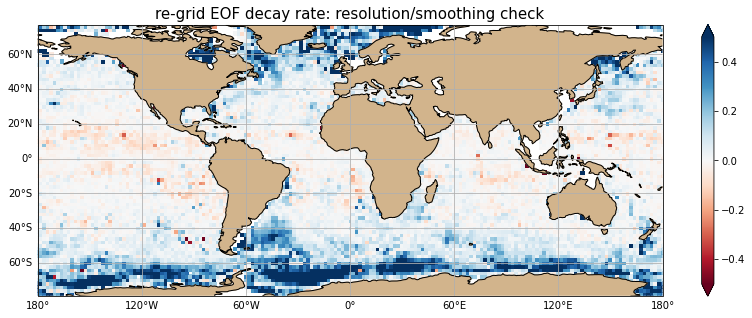

In [20]:
f, ax = plt.subplots(1,1,figsize=(14,5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
# N2_da.sel(depth=z_grid[5]).plot(ax=ax,transform=ccrs.PlateCarree(), cmap=plt.get_cmap('jet'), add_colorbar=True, vmin=0,vmax=0.0001) 
# alpha_da.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=plt.get_cmap('viridis'), add_colorbar=True, vmin=-0.01,vmax=0.01) 
pct_decay_v_da.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=plt.get_cmap('RdBu'), add_colorbar=True, vmin=-0.5,vmax=0.5) 
# ax.scatter(320.5,32.5,color='m')
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True)
ax.set_title('re-grid EOF decay rate: resolution/smoothing check',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_06_14/eof_decay_smooth_2deg.jpg', dpi=300)

In [32]:
lon_check = 310
lat_check = -68
i1 = np.where((lon1 > lon_check) & (lon1 < lon_check+1))[0][0]
j1 = np.where((lat_trim >= lat_check) & (lat_trim < lat_check+0.5))[0][0]
i2 = np.where((lon_grid >= lon_check) & (lon_grid <= lon_check+1))[0][0]
j2 = np.where((lat_grid >= lat_check) & (lat_grid <= lat_check+1))[0][0]
print(i2)
print(j2)
print(str(lon1[i1]) + ', ' + str(lat_trim[j1]))
print(str(lon_grid[i2]) + ', ' + str(lat_grid[j2]))

155
5
310.0499999999947, -67.59203827659981
310, -68


In [33]:
np.shape(N2_out)
N2_out[:,j2,i2]
z_grid[-12]

3092.1171875

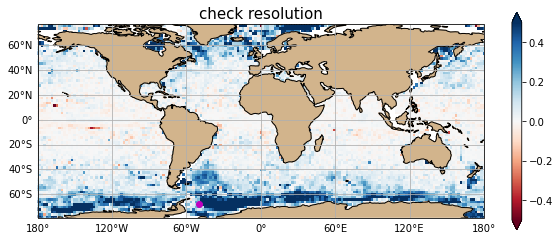

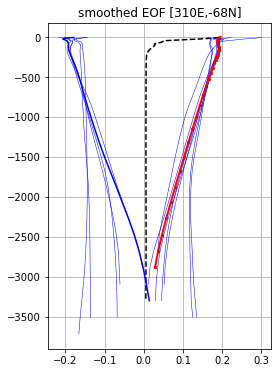

In [34]:
f, ax = plt.subplots(1,1,figsize=(10,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
pct_decay_da.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=plt.get_cmap('RdBu'), add_colorbar=True, vmin=-0.5,vmax=0.5) 
ax.scatter(lon_check,lat_check,color='m')
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True)
ax.set_title('check resolution',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False

f, ax = plt.subplots(1,1,figsize=(4,6))
ax.plot(2000*N2_out[:,j2,i2]+0.005,-1*z_grid,linestyle='--',color='k')
ax.plot(EOF1u_trim[:,j1,i1],-1*EOF_z,color='b')
ax.plot(-1*EOF1u_trim[:,j1-1,i1],-1*EOF_z,color='b',linewidth=0.5)
ax.plot(-1*EOF1u_trim[:,j1+1,i1],-1*EOF_z,color='b',linewidth=0.5)
ax.plot(-1*EOF1u_trim[:,j1-2,i1],-1*EOF_z,color='b',linewidth=0.5)
ax.plot(1*EOF1u_trim[:,j1+2,i1],-1*EOF_z,color='b',linewidth=0.5)
ax.plot(-1*EOF1u_trim[:,j1-3,i1],-1*EOF_z,color='b',linewidth=0.5)
ax.plot(-1*EOF1u_trim[:,j1+3,i1],-1*EOF_z,color='b',linewidth=0.5)

ax.plot(EOF1u_trim[:,j1,i1-1],-1*EOF_z,color='b',linewidth=0.5)
ax.plot(EOF1u_trim[:,j1,i1+1],-1*EOF_z,color='b',linewidth=0.5)
ax.plot(EOF1u_trim[:,j1,i1-2],-1*EOF_z,color='b',linewidth=0.5)
ax.plot(-1*EOF1u_trim[:,j1,i1+2],-1*EOF_z,color='b',linewidth=0.5)
ax.plot(EOF1u_trim[:,j1,i1-3],-1*EOF_z,color='b',linewidth=0.5)
ax.plot(EOF1u_trim[:,j1,i1+3],-1*EOF_z,color='b',linewidth=0.5)
ax.plot(EOFu_out[:,j2,i2],-1*z_grid,color='r',linewidth=2)
ax.scatter(EOFu_out[:,j2,i2],-1*z_grid,color='r',s=5)
# ax.set_xlim([0,0.3])
ax.set_title('smoothed EOF [' + str(lon_check) + 'E,' + str(lat_check) + 'N]')
ax.grid()
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_06_14/eof_decay_smooth_2deg_profile.jpg', dpi=300)

In [21]:
ds = xr.Dataset(
    data_vars=dict(
        N2=(['z','lat','lon'], N2_out),
        EOFu=(['z','lat','lon'], EOFu_out),
        EOFv=(['z','lat','lon'], EOFv_out),
        alpha=(['lat','lon'], alpha_out),
        gamma=(['lat','lon'], gamma_out),
    ),
    coords=dict(
        z=(['z'],z_grid),
        lat=(['lat'],lat_grid),
        lon=(['lon'],lon_grid),
    )
)

In [22]:
ds.to_netcdf(path='/Users/jakesteinberg/Documents/CPT/vertical_structure/CM_comparisons/prep_for_modes_cmN_2deg_UV.nc')

In [35]:
N2_out[:,j2,i2]

array([9.36848360e-05, 8.29665458e-05, 6.63398999e-05, 4.44613498e-05,
       2.37169880e-05, 2.19747836e-05, 1.96858730e-05, 1.32189997e-05,
       1.10826473e-05, 1.17700890e-05, 1.09064699e-05, 9.69315196e-06,
       7.95209026e-06, 5.96536828e-06, 4.48711329e-06, 3.01470675e-06,
       2.18007953e-06, 1.27216180e-06, 1.01732028e-06, 6.74690530e-07,
       6.24201634e-07, 4.98378514e-07, 5.00757565e-07, 4.34988797e-07,
       4.23394030e-07, 4.00023881e-07, 3.60529676e-07, 3.28441403e-07,
       3.14297712e-07, 3.10025040e-07, 3.18921712e-07, 3.36252503e-07,
       3.62895179e-07, 3.98867063e-07, 4.51876874e-07, 5.07799556e-07,
       4.84166716e-07, 3.46100514e-07, 2.37352576e-07, 1.68359478e-07,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan])